Generate hourly prediction for future data by simply averaging historical data, and scale it according to the weekly prediction provided.

# Preparation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv, find_dotenv
import sys
sys.path.append('../')

In [2]:
# data directories
load_dotenv(find_dotenv(), verbose=True)
dir_project = os.getenv('PROJECT_ROOT')
dir_data_raw = os.path.join(dir_project, 'data/raw/')
dir_data_interim = os.path.join(dir_project, 'data/interim/')
dir_data_processed = os.path.join(dir_project, 'data/processed/')
dir_data_external = os.path.join(dir_project, 'data/external/')
dir_models = os.path.join(dir_project, 'models/')

Load data:  

In [3]:
path_data = os.path.join(dir_data_interim, 'Clean_Hourly_Data.csv')

In [4]:
df_origin = pd.read_csv(path_data)
df_origin.Date = pd.to_datetime(df_origin.Date + ' ' + df_origin.Hour)
df_origin.set_index('Date', inplace=True)

In [5]:
df_origin.head()

,Hour,HOEP,Ontario.Demand,NUCLEAR,GAS,HYDRO,WIND,SOLAR,BIOFUEL,Temp,Holidays,season_Fall,season_Spring,season_Summer,season_Winter,month,dayofweek,CDD,HDD
Date,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,00:00:00,3.28,14960,11564,957,3173,2504,0.0,20,-6.2,1,0,0,0,1,1,3,0.0,24.53
2015-01-01 01:00:00,01:00:00,0.00,14476,11560,946,3100,2262,0.0,20,-6.0,1,0,0,0,1,1,3,0.0,24.33
2015-01-01 02:00:00,02:00:00,0.00,13979,11560,947,3051,2025,0.0,20,-6.2,1,0,0,0,1,1,3,0.0,24.53
2015-01-01 03:00:00,03:00:00,0.00,13670,11444,949,3086,1950,0.0,22,-6.0,1,0,0,0,1,1,3,0.0,24.33
2015-01-01 04:00:00,04:00:00,0.00,13567,11174,946,3131,2015,0.0,21,-6.0,1,0,0,0,1,1,3,0.0,24.33


In [6]:
len(df_origin)

48360

In [7]:
independ_vars = ['HOEP', 'Ontario.Demand', 'Temp', 'NUCLEAR', 'GAS', 'HYDRO', 'WIND', 'SOLAR', 'BIOFUEL']
df = df_origin[independ_vars]

Leave `CDD`, `HDD` aside since it's calculated from `Temp`.

Missing `dew point` in the data.

# Split Data

In [8]:
df_train = df[df.index.year < 2018].copy()
#df_test = df[df.index.year >= 2018].copy()

# Average hourly data

Since the largest seasonality is annual, we will split historical data into years and average the data of every hour in the year.  
So we will index by Month/Year/Hour:

In [9]:
df_train['Month'] = df_train.index.month
df_train['Day'] = df_train.index.day
df_train['Hour'] = df_train.index.hour

df_train.set_index(['Month', 'Day', 'Hour'], inplace=True)

In [10]:
df_train

HOEP  Ontario.Demand  Temp  NUCLEAR   GAS  HYDRO  WIND  \
Month Day Hour                                                            
1     1   0      3.28           14960  -6.2    11564   957   3173  2504   
          1      0.00           14476  -6.0    11560   946   3100  2262   
          2      0.00           13979  -6.2    11560   947   3051  2025   
          3      0.00           13670  -6.0    11444   949   3086  1950   
          4      0.00           13567  -6.0    11174   946   3131  2015   
...               ...             ...   ...      ...   ...    ...   ...   
12    31  19    40.04           18706 -13.7    11681  3032   5110  1201   
          20    39.71           18284 -14.5    11675  2853   4978  1180   
          21    39.37           17772 -15.0    11682  2721   4525  1214   
          22    39.79           17228 -15.5    11677  2715   3918  1164   
          23    42.56           16842 -15.8    11680  2526   3739  1049   

                SOLAR  BIOFUEL  
Month Day Hour                  
1     1   0       0.0       20  
          1       0.0       20  
          2       0.0       20  
          3       0.0       22  
          4       0.0       21  
...               ...      ...  
12    31  19      0.0        8  
          20      0.0        6  
          21      0.0        0  
          22      0.0        1  
          23      0.0        3  

[26304 rows x 9 columns]

In [11]:
df_average = df_train.mean(level=[0,1,2])
df_average

HOEP  Ontario.Demand      Temp       NUCLEAR          GAS  \
Month Day Hour                                                                  
1     1   0     0.730000    13966.333333 -1.200000  11448.000000   703.333333   
          1    -0.803333    13520.333333 -1.200000  11390.666667   699.666667   
          2    -1.410000    13063.333333 -1.466667  11353.333333   700.333333   
          3    -1.466667    12834.333333 -1.333333  11159.666667   702.333333   
          4    -1.480000    12748.666667 -1.333333  11065.333333   700.666667   
...                  ...             ...       ...           ...          ...   
2     29  19    0.000000    18853.000000 -1.800000  11357.000000  1181.000000   
          20    4.820000    18701.000000 -4.000000  11358.000000  1176.000000   
          21    1.790000    18022.000000 -4.800000  11357.000000  1169.000000   
          22    0.970000    17083.000000 -5.300000  11358.000000  1170.000000   
          23    6.030000    16224.000000 -5.600000  11358.000000   991.000000   

                      HYDRO         WIND  SOLAR    BIOFUEL  
Month Day Hour                                              
1     1   0     2874.000000  2064.000000    0.0   8.000000  
          1     2874.000000  1913.000000    0.0   8.000000  
          2     2842.333333  1601.666667    0.0   9.666667  
          3     2861.666667  1561.000000    0.0  10.000000  
          4     2879.000000  1507.000000    0.0   8.000000  
...                     ...          ...    ...        ...  
2     29  19    5409.000000  2683.000000    0.0   0.000000  
          20    5335.000000  2756.000000    0.0   0.000000  
          21    5179.000000  2273.000000    0.0   0.000000  
          22    5012.000000  1910.000000    0.0   0.000000  
          23    4825.000000  1533.000000    0.0   0.000000  

[8784 rows x 9 columns]

8784 = 366*24 since there are 366 days in year 2016 (leap year).

# Visualize

The historical (train) data is from 2015/01/01 to 2018/12/31.

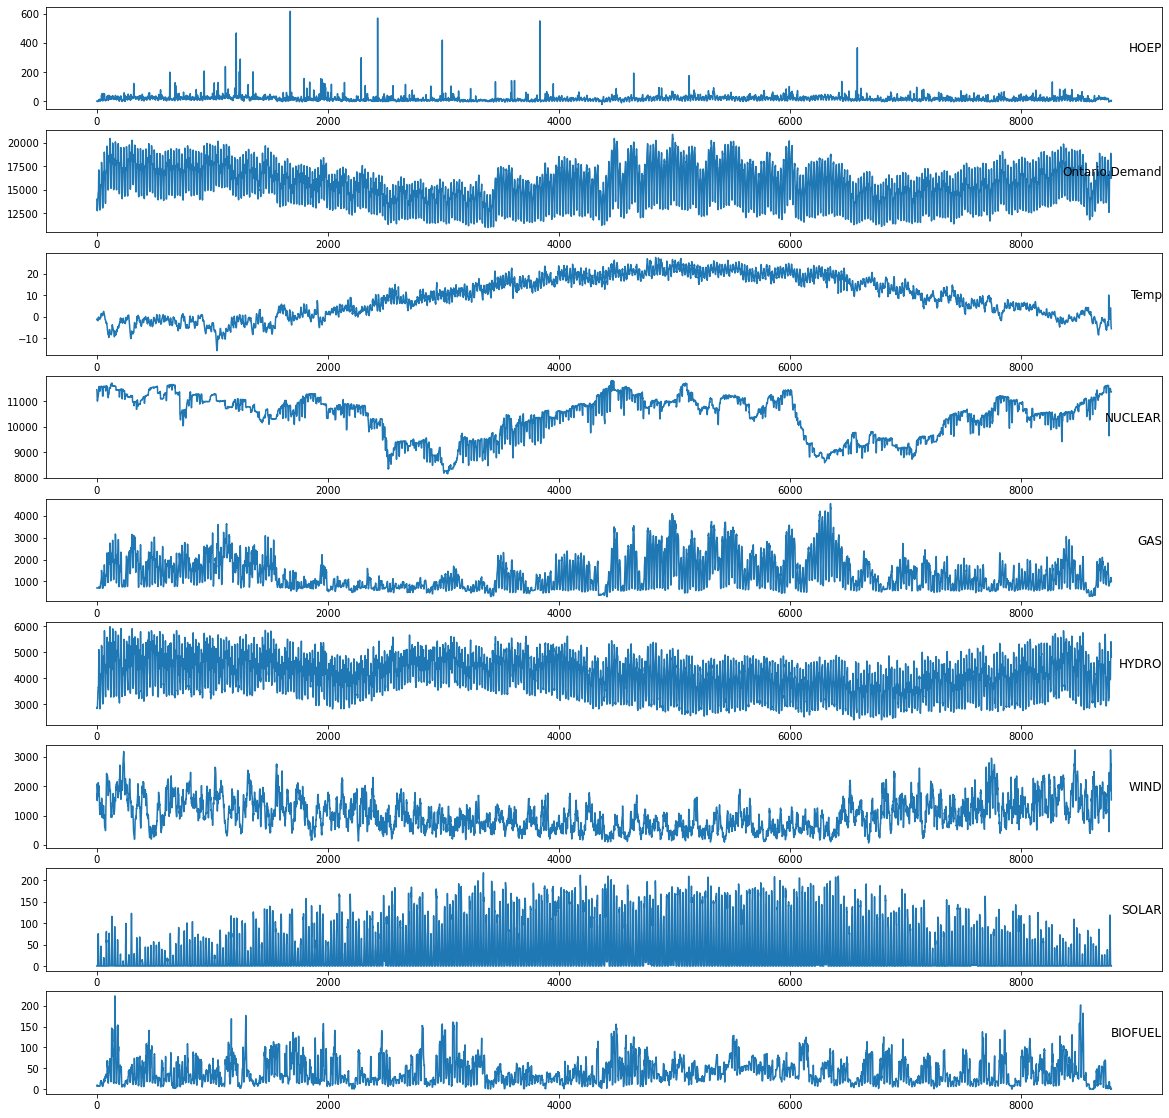

In [12]:
values = df_average.values
# specify columns to plot
cols = range(0, values.shape[1])
i = 1
# plot each column
plt.figure(figsize=(20, 20))
for col in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, col])
	plt.title(df.columns[col], y=0.5, loc='right')
	i += 1
plt.show()

- One month sample data:

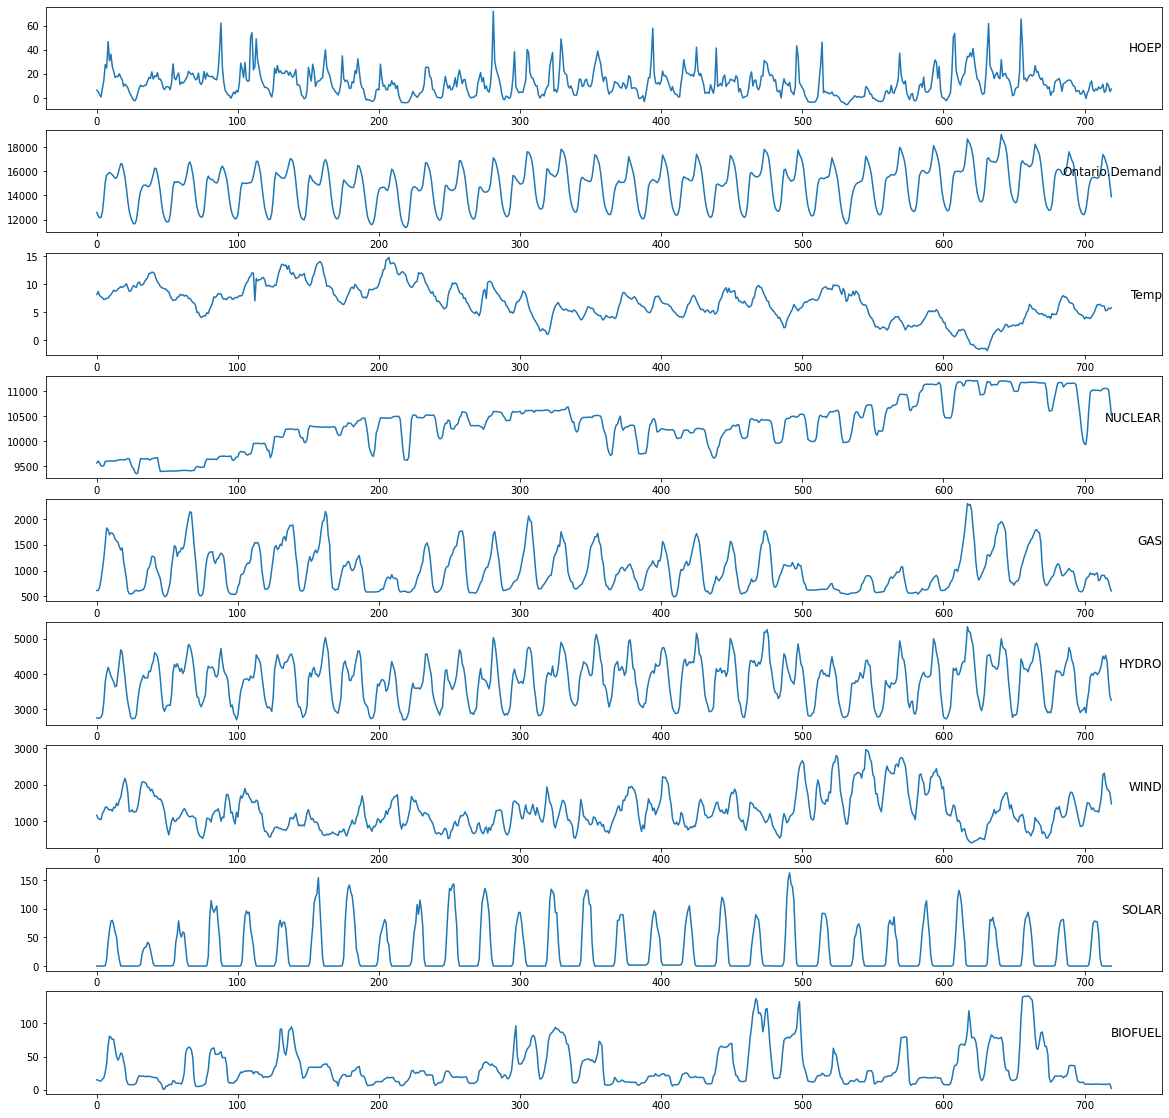

In [13]:
cols = range(0, values.shape[1])
i = 1
# plot each column
plt.figure(figsize=(20, 20))
for col in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[720*10:720*11, col])
	plt.title(df.columns[col], y=0.5, loc='right')
	i += 1
plt.show()

- One day sample:

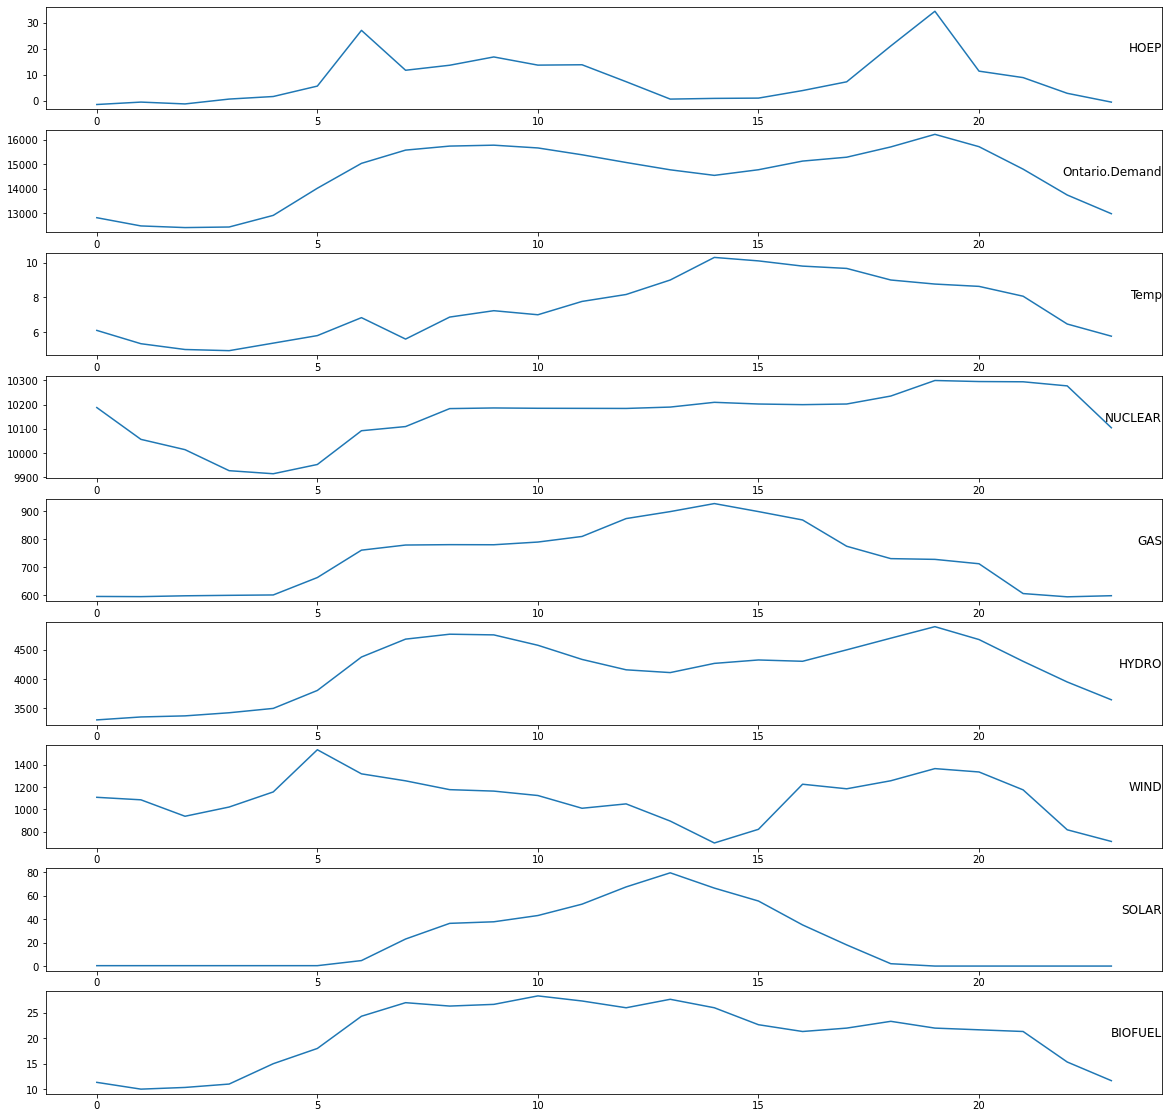

In [14]:
cols = range(0, values.shape[1])
i = 1
# plot each column
plt.figure(figsize=(20, 20))
for col in cols:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[24*100:24*101, col])
	plt.title(df.columns[col], y=0.5, loc='right')
	i += 1
plt.show()

We can find clear seasonnal and daily patterns on most of the variables.

One thing that misses is this average **doesn't count weekly pattern**, nor does it capture some holiday information.

# Scale by weekly outlook

## Load the weekly outlook:

In [15]:
df_outlook_origin = pd.read_excel(os.path.join(dir_data_raw, 'Data 18 months Outlook/09-01-2018/09012018.xlsx'), sheet_name='Feuil1')
independ_vars = ['Ontario ED', 'Normal Average Temperature (°C)', 'Expected Nuclear Output', 
                 'Expected Hydro Output', 'Expected Wind Output', 'Expected Self-Scheduling & Intermittent Output']
df_outlook = df_outlook_origin[['Date (week ending)', 'HOEP'] + independ_vars].copy()

In [16]:
df_outlook.head(2)

,Date (week ending),HOEP,Ontario ED,Normal Average Temperature (°C),Expected Nuclear Output,Expected Hydro Output,Expected Wind Output,Expected Self-Scheduling & Intermittent Output
0,2018-10-07 23:00:00,13.142262,2391.277026,12.447619,10636,2322,1389.592284,43.629131
1,2018-10-14 23:00:00,6.506905,2373.296952,9.871429,10666,2322,1389.592284,43.629131


In [17]:
df_outlook['Week'] = df_outlook['Date (week ending)'].apply(lambda x: x.isocalendar()[1])

Average Demand into hourly:

In [18]:
# GWh -> MWh, need *1000
df_outlook['Ontario ED'] = df_outlook['Ontario ED']*1000/168

Rename cols to match the other df:

In [19]:
df_outlook.rename(columns={"Ontario ED": "Ontario.Demand", "Normal Average Temperature (°C)": "Temp", 
                          'Expected Nuclear Output': 'NUCLEAR', 'Expected Hydro Output': 'HYDRO', 
                          'Expected Wind Output': 'WIND', 'Expected Self-Scheduling & Intermittent Output': 'Intermittent_Output'}, 
                  inplace = True)

In [20]:
independ_vars = df_outlook.drop(columns=['Date (week ending)', 'HOEP', 'Week']).columns.to_list()

In [21]:
independ_vars

['Ontario.Demand', 'Temp', 'NUCLEAR', 'HYDRO', 'WIND', 'Intermittent_Output']

In [22]:
df_outlook

,Date (week ending),HOEP,Ontario.Demand,Temp,NUCLEAR,HYDRO,WIND,Intermittent_Output,Week
0,2018-10-07 23:00:00,13.142262,14233.791821,12.447619,10636,2322,1389.592284,43.629131,40
1,2018-10-14 23:00:00,6.506905,14126.767570,9.871429,10666,2322,1389.592284,43.629131,41
2,2018-10-21 23:00:00,3.615893,14383.648426,7.709524,10666,2322,1389.592284,43.629131,42
3,2018-10-28 23:00:00,22.999821,14631.952991,7.519048,10666,2322,1389.592284,43.629131,43
4,2018-11-04 23:00:00,24.625060,14714.398640,7.638095,10736,2573,1715.272998,67.406749,44
...,...,...,...,...,...,...,...,...,...
74,2020-03-08 23:00:00,14.819524,15961.565011,0.514286,9480,2387,1624.111594,85.057643,10
75,2020-03-15 23:00:00,12.702321,15396.518269,1.433333,9996,2387,1624.111594,85.057643,11
76,2020-03-22 23:00:00,15.028393,14897.584186,4.414286,9996,2387,1624.111594,85.057643,12
77,2020-03-29 23:00:00,12.208095,14900.644217,4.619048,9118,2387,1624.111594,85.057643,13


## Compute historical weekly average:

There are 52 or 53 ISO weeks in a year, for simplification, we won't concern too much about the distinction between week 52, 53 and 1.

Take the mean of every 7 days in the df_average as the weekly average:

In [23]:
df_average['Week'] = np.arange(len(df_average))//(7*24) + 1

In [24]:
df_average_weekly = df_average.groupby('Week').mean()

Align the variables with the outlook:  
`GAS + SOLAR + BIOFUEL = Expected Self-Scheduling & Intermittent Output`

In [25]:
df_average_weekly['Intermittent_Output'] = df_average_weekly[['SOLAR', 'BIOFUEL']].sum(axis=1)

In [26]:
df_average_weekly.drop(columns = ['SOLAR', 'BIOFUEL', 'GAS'], inplace=True)

In [27]:
df_average_weekly.head()

,HOEP,Ontario.Demand,Temp,NUCLEAR,HYDRO,WIND,Intermittent_Output
Week,,,,,,,
1,16.855119,16449.585317,-3.520437,11485.662698,4312.841270,1491.494048,56.333333
2,20.944226,17286.192460,-3.796627,11242.079365,4516.591270,1711.783730,44.541667
3,23.290437,17056.867063,-2.059508,11195.894841,4558.428571,1122.202381,58.505952
4,20.157222,16643.732143,-1.447619,11411.740079,4485.926587,1264.430556,37.898810
5,20.918075,16887.718254,-2.704746,10944.220238,4460.285714,1554.204365,51.172619


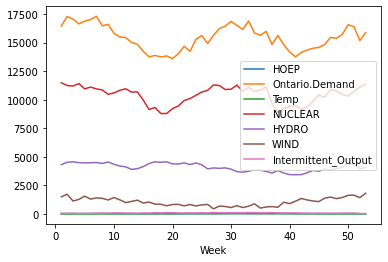

In [28]:
df_average_weekly.plot()

By comparison:

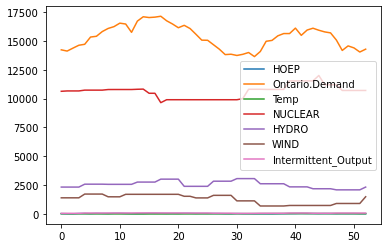

In [29]:
df_outlook[['HOEP'] + independ_vars][:53].plot()

Historical average price vs. realized price:

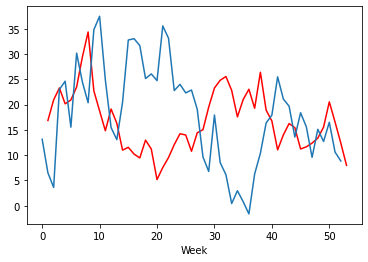

In [30]:
df_average_weekly['HOEP'].plot(color='r')
df_outlook['HOEP'][:53].plot()

The corresponding variables are in the same magnitude.

## Transform weekly outlook into hourly by scaling the hourly average

### Calculate the scale

In [31]:
print(df_outlook.shape)
print(df_average_weekly.shape)

(79, 9)
(53, 7)


In [32]:
df_average_weekly.head(1)

,HOEP,Ontario.Demand,Temp,NUCLEAR,HYDRO,WIND,Intermittent_Output
Week,,,,,,,
1,16.855119,16449.585317,-3.520437,11485.662698,4312.84127,1491.494048,56.333333


In [33]:
df_outlook.head(1)

,Date (week ending),HOEP,Ontario.Demand,Temp,NUCLEAR,HYDRO,WIND,Intermittent_Output,Week
0,2018-10-07 23:00:00,13.142262,14233.791821,12.447619,10636,2322,1389.592284,43.629131,40


In [34]:
df_outlook_scale = df_outlook.copy()

In [35]:
for i, row in df_outlook_scale.iterrows():
    week = row['Week']
    for var in df_average_weekly.columns:
        df_outlook_scale[var+'_scale'] = row[var] / df_average_weekly.loc[week, var]

In [36]:
df_outlook_scale

,Date (week ending),HOEP,Ontario.Demand,Temp,NUCLEAR,HYDRO,WIND,Intermittent_Output,Week,HOEP_scale,Ontario.Demand_scale,Temp_scale,NUCLEAR_scale,HYDRO_scale,WIND_scale,Intermittent_Output_scale
0,2018-10-07 23:00:00,13.142262,14233.791821,12.447619,10636,2322,1389.592284,43.629131,40,0.773771,0.985767,2.174917,0.853195,0.716268,1.429391,1.191677
1,2018-10-14 23:00:00,6.506905,14126.767570,9.871429,10666,2322,1389.592284,43.629131,41,0.773771,0.985767,2.174917,0.853195,0.716268,1.429391,1.191677
2,2018-10-21 23:00:00,3.615893,14383.648426,7.709524,10666,2322,1389.592284,43.629131,42,0.773771,0.985767,2.174917,0.853195,0.716268,1.429391,1.191677
3,2018-10-28 23:00:00,22.999821,14631.952991,7.519048,10666,2322,1389.592284,43.629131,43,0.773771,0.985767,2.174917,0.853195,0.716268,1.429391,1.191677
4,2018-11-04 23:00:00,24.625060,14714.398640,7.638095,10736,2573,1715.272998,67.406749,44,0.773771,0.985767,2.174917,0.853195,0.716268,1.429391,1.191677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,2020-03-08 23:00:00,14.819524,15961.565011,0.514286,9480,2387,1624.111594,85.057643,10,0.773771,0.985767,2.174917,0.853195,0.716268,1.429391,1.191677
75,2020-03-15 23:00:00,12.702321,15396.518269,1.433333,9996,2387,1624.111594,85.057643,11,0.773771,0.985767,2.174917,0.853195,0.716268,1.429391,1.191677
76,2020-03-22 23:00:00,15.028393,14897.584186,4.414286,9996,2387,1624.111594,85.057643,12,0.773771,0.985767,2.174917,0.853195,0.716268,1.429391,1.191677
77,2020-03-29 23:00:00,12.208095,14900.644217,4.619048,9118,2387,1624.111594,85.057643,13,0.773771,0.985767,2.174917,0.853195,0.716268,1.429391,1.191677


### Expand to hourly  
Do it week by week:

In [37]:
list_dfs_outlook_hourly = [None]*len(df_outlook_scale)

In [38]:
df_average.head(2)

HOEP  Ontario.Demand  Temp       NUCLEAR         GAS  \
Month Day Hour                                                             
1     1   0     0.730000    13966.333333  -1.2  11448.000000  703.333333   
          1    -0.803333    13520.333333  -1.2  11390.666667  699.666667   

                 HYDRO    WIND  SOLAR  BIOFUEL  Week  
Month Day Hour                                        
1     1   0     2874.0  2064.0    0.0      8.0     1  
          1     2874.0  1913.0    0.0      8.0     1

In [39]:
df_average.columns

Index(['HOEP', 'Ontario.Demand', 'Temp', 'NUCLEAR', 'GAS', 'HYDRO', 'WIND',
       'SOLAR', 'BIOFUEL', 'Week'],
      dtype='object')

In [40]:
import copy
for i, row in df_outlook_scale.iterrows():
    week = row.Week
    df_outlook_hourly_ithWeek = df_average[df_average.Week==week].copy()
    for var in ['Ontario.Demand', 'Temp', 'NUCLEAR', 'HYDRO', 'WIND']:
        df_outlook_hourly_ithWeek[var + '_scaled'] = df_outlook_hourly_ithWeek[var]*row[var+'_scale']
    for var in ['SOLAR', 'BIOFUEL']:
        df_outlook_hourly_ithWeek[var + '_scaled'] = df_outlook_hourly_ithWeek[var]*row['Intermittent_Output_scale']
    
    list_dfs_outlook_hourly[i] = df_outlook_hourly_ithWeek.copy()

In [41]:
df_outlook_hourly_scaled = pd.concat(list_dfs_outlook_hourly)

In [42]:
cols = ['Week','HOEP',
        'Ontario.Demand_scaled',
        'Temp_scaled',
        'NUCLEAR_scaled',
        'HYDRO_scaled',
        'WIND_scaled',
        'SOLAR_scaled',
        'BIOFUEL_scaled',
        'Ontario.Demand',
        'Temp',
        'NUCLEAR',
        'GAS',
        'HYDRO',
        'WIND',
        'SOLAR',
        'BIOFUEL']  # rearrange order

In [43]:
df_outlook_hourly_scaled = df_outlook_hourly_scaled[cols]

In [44]:
df_outlook_hourly_scaled.rename(columns = {'Ontario.Demand': 'Ontario.Demand_history', 'Temp': 'Temp_history',
                                          'NUCLEAR': 'NUCLEAR_history', 'GAS': 'GAS_history', 'HYDRO': 'HYDRO_history',
                                          'WIND': 'WIND_history', 'SOLAR': 'SOLAR_history', 'BIOFUEL': 'BIOFUEL_history'},
                               inplace=True)

In [45]:
df_outlook_hourly_scaled

Week       HOEP  Ontario.Demand_scaled  Temp_scaled  \
Month Day Hour                                                        
10    1   0       40   8.370000           11585.714752    24.576565   
          1       40   7.893333           11273.883920    24.069084   
          2       40   6.913333           11108.932310    22.981626   
          3       40   2.093333           11127.333286    22.256653   
          4       40   3.793333           11427.992097    21.459184   
...              ...        ...                    ...          ...   
4     8   19      14  22.600000           16584.208549     8.119691   
          20      14  10.566667           16086.396420     6.814741   
          21      14  19.533333           15210.049920     5.074807   
          22      14  13.856667           14079.047051     4.277337   
          23      14   3.853333           13273.347156     3.914851   

                NUCLEAR_scaled  HYDRO_scaled  WIND_scaled  SOLAR_scaled  \
Month Day Hour                                                            
10    1   0        8194.656471   1825.051760  1479.419568      0.000000   
          1        8156.262682   1776.584268  1324.092425      0.000000   
          2        8159.675463   1719.760312  1259.769835      0.000000   
          3        8153.134299   1729.071801  1130.171728      0.000000   
          4        8158.537870   1788.522074  1100.154519      0.000000   
...                        ...           ...          ...           ...   
4     8   19       8946.037133   3672.069083  1212.123472      0.397226   
          20       8790.471189   3477.960360  1224.511526      0.000000   
          21       8750.086612   3266.899952  1426.055641      0.000000   
          22       8745.820635   2911.392094  1359.827197      0.000000   
          23       8635.758441   2627.749826  1190.206145      0.000000   

                BIOFUEL_scaled  Ontario.Demand_history  Temp_history  \
Month Day Hour                                                         
10    1   0           4.766708            11753.000000     11.300000   
          1           4.369483            11436.666667     11.066667   
          2           5.561160            11269.333333     10.566667   
          3           6.752837            11288.000000     10.233333   
          4           6.752837            11593.000000      9.866667   
...                        ...                     ...           ...   
4     8   19         30.586379            16823.666667      3.733333   
          20         26.614122            16318.666667      3.133333   
          21         26.216897            15429.666667      2.333333   
          22         17.477931            14282.333333      1.966667   
          23         14.697351            13465.000000      1.800000   

                NUCLEAR_history  GAS_history  HYDRO_history  WIND_history  \
Month Day Hour                                                              
10    1   0         9604.666667   582.333333    2548.000000   1035.000000   
          1         9559.666667   580.666667    2480.333333    926.333333   
          2         9563.666667   602.666667    2401.000000    881.333333   
          3         9556.000000   639.333333    2414.000000    790.666667   
          4         9562.333333   704.666667    2497.000000    769.666667   
...                         ...          ...            ...           ...   
4     8   19       10485.333333  1333.000000    5126.666667    848.000000   
          20       10303.000000  1164.000000    4855.666667    856.666667   
          21       10255.666667   849.666667    4561.000000    997.666667   
          22       10250.666667   669.666667    4064.666667    951.333333   
          23       10121.666667   665.000000    3668.666667    832.666667   

                SOLAR_history  BIOFUEL_history  
Month Day Hour                                  
10    1   0          0.000000         4.000000  
          1          0.000000 

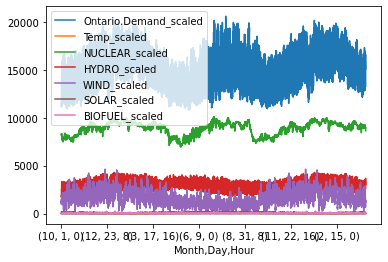

In [46]:
df_outlook_hourly_scaled.loc[:,'Ontario.Demand_scaled': 'BIOFUEL_scaled'].plot()

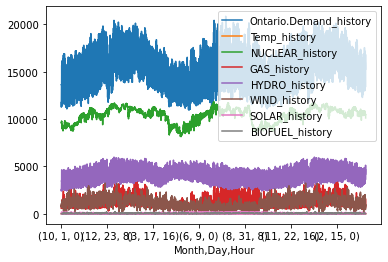

In [47]:
df_outlook_hourly_scaled.loc[:,'Ontario.Demand_history': 'BIOFUEL_history'].plot()

## Format transform

In [48]:
target_cols = ['Date (week ending)', 'HOEP', 'Ontario ED', 'Normal Average Temperature (Â°C)', 'Expected Nuclear Output', 'Expected Hydro Output', 'Expected Wind Output', 'Expected Self-Scheduling & Intermittent Output']

In [49]:
df_outlook_hourly_scaled['Expected Self-Scheduling & Intermittent Output'] = \
df_outlook_hourly_scaled['SOLAR_scaled'] + df_outlook_hourly_scaled['BIOFUEL_scaled']

In [50]:
list_to_output = cols = ['HOEP',
        'Ontario.Demand_scaled',
        'Temp_scaled',
        'NUCLEAR_scaled',
        'HYDRO_scaled',
        'WIND_scaled',
        'Expected Self-Scheduling & Intermittent Output']

In [51]:
df_outlook_hourly_scaled_output = df_outlook_hourly_scaled[list_to_output].copy()

In [52]:
starting_time = df_outlook['Date (week ending)'][0] - pd.Timedelta('7 day')

In [53]:
df_outlook_hourly_scaled_output['Date (week ending)'] = \
pd.date_range(start=starting_time, periods=len(df_outlook_hourly_scaled_output)+1, closed='right', freq='H')

In [54]:
df_outlook_hourly_scaled_output.set_index('Date (week ending)', inplace=True)
df_outlook_hourly_scaled_output.reset_index(inplace=True)

In [55]:
df_outlook_hourly_scaled_output.columns = target_cols

In [56]:
df_outlook_hourly_scaled_output

,Date (week ending),HOEP,Ontario ED,Normal Average Temperature (Â°C),Expected Nuclear Output,Expected Hydro Output,Expected Wind Output,Expected Self-Scheduling & Intermittent Output
0,2018-10-01 00:00:00,8.370000,11585.714752,24.576565,8194.656471,1825.051760,1479.419568,4.766708
1,2018-10-01 01:00:00,7.893333,11273.883920,24.069084,8156.262682,1776.584268,1324.092425,4.369483
2,2018-10-01 02:00:00,6.913333,11108.932310,22.981626,8159.675463,1719.760312,1259.769835,5.561160
3,2018-10-01 03:00:00,2.093333,11127.333286,22.256653,8153.134299,1729.071801,1130.171728,6.752837
4,2018-10-01 04:00:00,3.793333,11427.992097,21.459184,8158.537870,1788.522074,1100.154519,6.752837
...,...,...,...,...,...,...,...,...
13267,2020-04-05 19:00:00,22.600000,16584.208549,8.119691,8946.037133,3672.069083,1212.123472,30.983605
13268,2020-04-05 20:00:00,10.566667,16086.396420,6.814741,8790.471189,3477.960360,1224.511526,26.614122
13269,2020-04-05 21:00:00,19.533333,15210.049920,5.074807,8750.086612,3266.899952,1426.055641,26.216897
13270,2020-04-05 22:00:00,13.856667,14079.047051,4.277337,8745.820635,2911.392094,1359.827197,17.477931


In [57]:
df_outlook_hourly_scaled_output.to_csv(os.path.join(dir_data_processed, 'hourly_outlook_09012018_from_HistoryAverageScaledByWeeklyOutlook.csv'),
                                      index=False)